# Figure S4

In [48]:
import scanpy as sc
import anndata as ad
import scportrait
import spatialdata
import spatialdata_plot

import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex

# Create a continuous colormap from defined colors
color_list =  ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)

def generate_palette(n_colors, custom_cmap):
    palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]

    # convert to hex colors 
    palette = [to_hex(x) for x in palette]
    return(palette)


In [2]:
# define plotting parameters for consistency across figures and vector graphic export
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
anndata_file_all_results = '../figure_data/input_data_Xenium/xenium_ovarian_cancer_full.h5ad'
sdata_file_path = "../figure_data/input_data_Xenium/scportrait.sdata"
h5sc_path = '../figure_data/input_data_Xenium/single_cells.h5sc'
figures_directory = "../manuscript_figures/Figure_S4/"
px_size = 0.2125 #µm
os.makedirs(figures_directory, exist_ok=True)

In [4]:
data = sc.read_h5ad(anndata_file_all_results)
h5sc = scportrait.io.read_h5sc(h5sc_path)
sdata = spatialdata.read_zarr(sdata_file_path)

version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Fig S4a Test Set Xenium Cell Types

In [18]:
# get correct embedding and subset to test set
plot_data = ad.AnnData(
    X=data.obsm['X_vitmae_finetuned_img_features'],
    obs=data.obs,
)
plot_data = plot_data[plot_data.obs['is_in_vitmae_test_set']]

In [19]:
# using single-cell rapids to calculate TSNE and UMAP embeddings requires a CUDA-enabled Nvidia GPU
# check for Nvidia GPU and configure for use with GPU accelerated rapids single-cell
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with GPU-accelerated computations.")
    
    # import packages for GPU-accelerated analysis
    import rmm
    import cupy as cp
    import rapids_singlecell as rsc
    from cuml.manifold import TSNE
    
    from rmm.allocators.cupy import rmm_cupy_allocator

    # initialize RAPIDS memory manager
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=2 << 30,  # 2GB
        devices=list(map(int, os.environ.get("CUDA_VISIBLE_DEVICES").split(","))),
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)
    
    # scale data
    sc.pp.scale(plot_data)

    # move data to GPU
    rsc.get.anndata_to_GPU(plot_data)

    # calculate PCs
    rsc.pp.pca(plot_data, n_comps=100)

    # calculate tSNE embedding
    rsc.tl.tsne(
        plot_data,
        n_pcs=100,
        perplexity=30,
        early_exaggeration=12,
        learning_rate=200,
    )

    # save results to file for reloading
    pd.DataFrame(
        {
            'cell_id': plot_data.obs['cell_id'],
            'cell_label': plot_data.obs['cell_labels'],
            '10X_cell_type': plot_data.obs['10X_cell_type'],
            'tsne_x': plot_data.obsm['X_tsne'][:,0],
            'tsne_y': plot_data.obsm['X_tsne'][:,1],
        }
    ).to_csv('../figure_data/input_data_Xenium/test_set_tsne_coordinates.csv', index=False)
else:
    print("GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.")
    tsne_coordinates = pd.read_csv('../figure_data/input_data_Xenium/test_set_tsne_coordinates.csv')
    tsne_coordinates.set_index('cell_id', inplace=True)

    # add tsne coordinates to the anndata object for plotting
    cell_ids = plot_data.obs.cell_id.tolist()
    plot_data.obsm["X_tsne"] = tsne_coordinates.loc[cell_ids].get(['tsne_x', 'tsne_y']).to_numpy()

GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.


/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_78954/1634178999.py:58: ImplicitModificationWarning: Setting element `.obsm['X_tsne']` of view, initializing view as actual.
  plot_data.obsm["X_tsne"] = tsne_coordinates.loc[cell_ids].get(['tsne_x', 'tsne_y']).to_numpy()


In [20]:
_plot_data = plot_data[plot_data.obs['10X_cell_type'] != 'Unassigned']

In [21]:
order = [
    'Tumor Cells',
    'Tumor Associated Endothelial Cells',
    'Pericytes',
    'SOX2-OT+ Tumor Cells',
    'Fallopian Tube Epithelium',
    'Smooth Muscle Cells',
    'Tumor Associated Fibroblasts',
    'Inflammatory Tumor Cells',
    'Macrophages',
    'Malignant Cells Lining Cyst',
    'T and NK Cells',
    'Ciliated Epithelial Cells',
    'Stromal Associated Fibroblasts',
    'Granulosa Cells',
    'Proliferative Tumor Cells',
    'Stromal Associated Endothelial Cells',
    'VEGFA+ Tumor Cells',
]
palette = generate_palette(len(order), custom_cmap=custom_cmap)
cluster_to_color_celltype = {cluster_label:palette[i] for i, cluster_label in enumerate(order)}

# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(_plot_data.obs['10X_cell_type'].cat.categories)
_plot_data.uns['10X_cell_type_colors'] = [cluster_to_color_celltype.get(c, na_color) for c in cats]

/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_78954/11612391.py:31: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  _plot_data.uns['10X_cell_type_colors'] = [cluster_to_color_celltype.get(c, na_color) for c in cats]


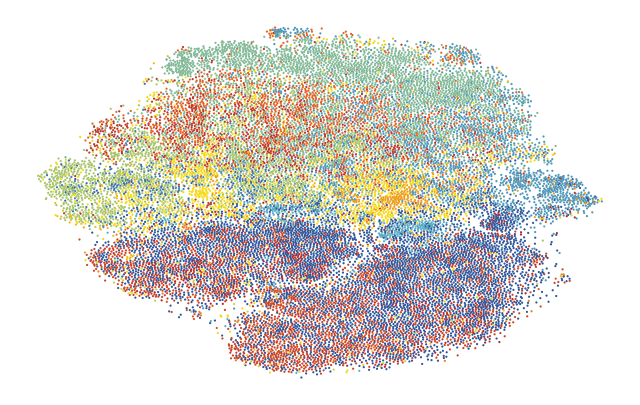

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

sc.pl.tsne(
    _plot_data,
    color = '10X_cell_type',
    ax = ax,
    s = 10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{figures_directory}/Fig_S4a.png', dpi=600, bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


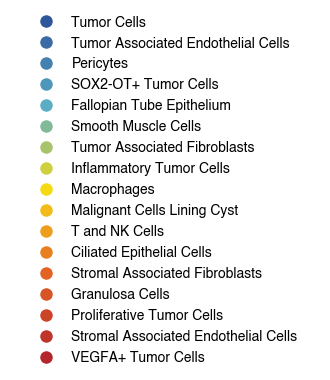

In [23]:
# Create figure containing the legend to the previously generated tSNE
df = pd.DataFrame({
    '10X_cell_type': order,
    'color': palette,
})

fig, ax = plt.subplots(figsize=(4, 4))
ax.axis("off")

# Build legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=row['10X_cell_type'])
    for _, row in df.iterrows()
]
ax.legend(handles=handles, loc='center', frameon=False)
fig.savefig(f"{figures_directory}/Fig_S4a_tSNE_legend.pdf", dpi=300, bbox_inches="tight")

## Fig S4b Transcriptome & Image Information Overlap

### Transcriptome Clusters on Images UMAP

#### calculate transcriptome clusters and visualize over transcriptome UMAP

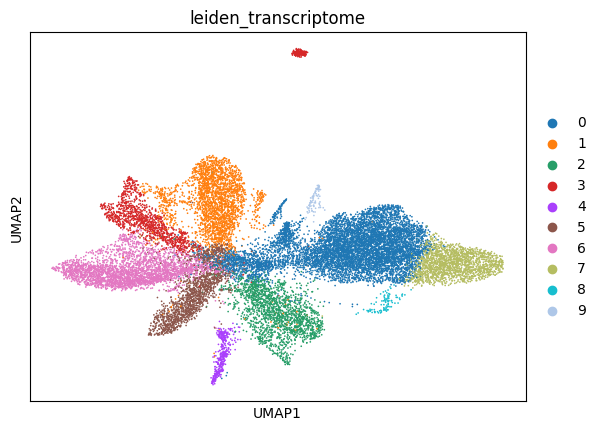

In [ ]:
test_data = data[data.obs['is_in_vitmae_test_set']].copy()

sc.pp.log1p(test_data)
sc.pp.highly_variable_genes(test_data)
sc.pp.scale(test_data)
rsc.get.anndata_to_GPU(test_data)
rsc.pp.neighbors(test_data)
rsc.tl.leiden(test_data, resolution=0.3, key_added='leiden_transcriptome')
rsc.tl.umap(test_data)

sc.pl.umap(
    test_data,
    color='leiden_transcriptome',
)

#### transfer transcriptome clusters and visualize over image UMAP

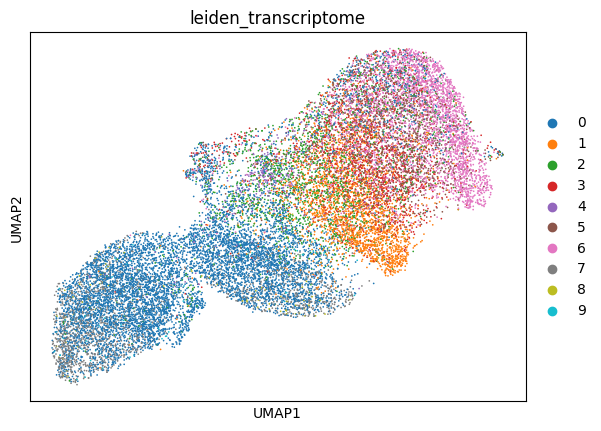

In [ ]:
plot_data = ad.AnnData(
    X=test_data.obsm['X_vitmae_finetuned_img_features'],
    obs=test_data.obs,
)

sc.pp.scale(plot_data)
rsc.pp.neighbors(plot_data)
rsc.tl.umap(plot_data)

sc.pl.umap(
    plot_data,
    color='leiden_transcriptome',
    )

### Transcriptome Clusters on Images TSNE

In [343]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [ ]:
sc.pp.log1p(test_data)
sc.pp.highly_variable_genes(test_data)
sc.pp.scale(test_data)
rsc.get.anndata_to_GPU(test_data)
rsc.pp.pca(test_data, n_comps=100)
rsc.pp.neighbors(test_data)
rsc.tl.leiden(test_data, resolution=0.3, key_added='leiden_transcriptome')
rsc.tl.tsne(
    test_data,
    n_pcs=20,
    perplexity=20,
    early_exaggeration=20,
    learning_rate=200,
)

In [398]:
color_list = ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)
n_colors = len(test_data.obs['leiden_transcriptome'].unique())
palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]
palette = [to_hex(x) for x in palette]
fig, ax = plt.subplots(figsize=(n_colors, 1))
for i, color in enumerate(palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.savefig(f'{out_dir}{n_colors}_colored_blocks.pdf', bbox_inches='tight')
plt.close()

In [399]:
cats = list(test_data.obs['leiden_transcriptome'].cat.categories)
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(cats)}
# white
na_color = '#FFFFFF'
test_data.uns['leiden_transcriptome_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

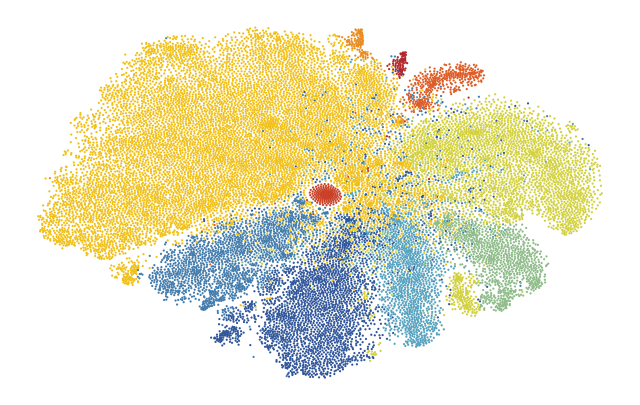

In [401]:
fig, ax = plt.subplots(figsize=(8, 5))
sc.pl.tsne(
    test_data,
    color='leiden_transcriptome',
    ax = ax,
    # s = 0.5,
    s=10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1b_transcriptome_space.png', dpi=600, bbox_inches='tight',)

In [308]:
tsne_data = pd.read_csv('Fig_S1/_all_cells_tsne.csv').merge(
    test_data.obs[['cell_id', 'leiden_transcriptome']],
    on='cell_id',
    how='left',
)

In [337]:
tsne_adata = ad.AnnData(
    obs=tsne_data,
)
tsne_adata.obsm['X_tsne'] = tsne_data[['tsne_x', 'tsne_y']].to_numpy()
tsne_adata.uns['leiden_transcriptome_colors'] = test_data.uns['leiden_transcriptome_colors']

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


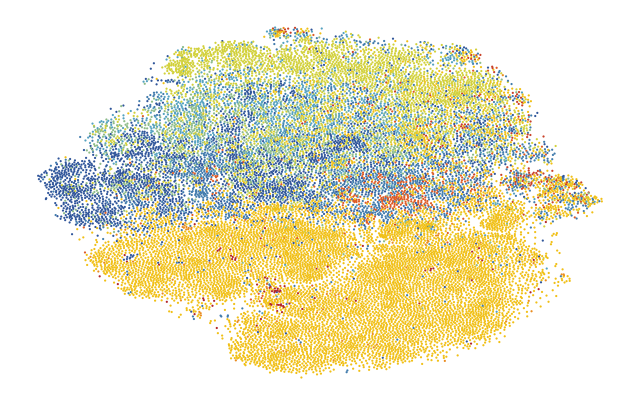

In [339]:
fig, ax = plt.subplots(figsize=(8, 5))

sc.pl.tsne(
    tsne_adata,
    color = 'leiden_transcriptome',
    ax = ax,
    # s = 0.5,
    s=10,
    alpha = 1,
    frameon=False,
    title='',
    legend_loc=None,
)
fig.savefig(f'{out_dir}Fig_S1b_image_space.png', dpi=600, bbox_inches='tight',)

### Image Clusters on Transcriptome

In [154]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()

In [155]:
img_data = ad.AnnData(
    X=test_data.obsm['X_vitmae_finetuned_img_features'],
    obs=test_data.obs,
)

In [156]:
sc.pp.scale(img_data)

In [157]:
rsc.get.anndata_to_GPU(img_data)

In [158]:
rsc.pp.neighbors(img_data)

[2025-09-06 11:06:56.216] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [159]:
rsc.tl.leiden(img_data, resolution=0.3, key_added='leiden_img')

In [160]:
rsc.tl.umap(img_data)

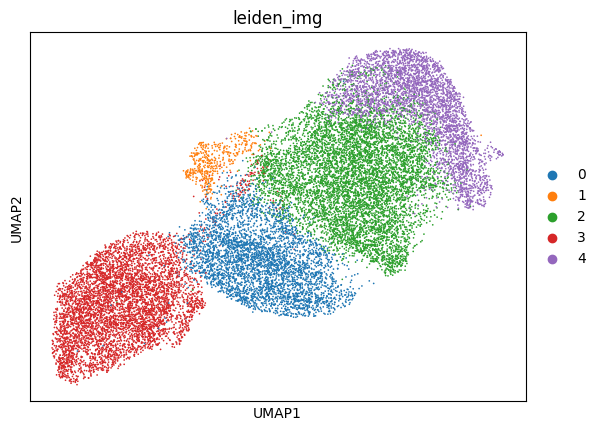

In [161]:
sc.pl.umap(
    img_data,
    color='leiden_img',
)

## Fig S4c knn neighborhood overlap to quantify difference between transcriptome- and image-based embeddings

In [24]:
import numpy as np
from typing import Iterable, Union, Dict, Any

def _pairwise_dists(X: np.ndarray, metric: str) -> np.ndarray:
    """Return full n×n distance matrix. diag set to +inf."""
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    if metric == "euclidean":
        xsq = np.sum(X**2, axis=1, keepdims=True)
        D = xsq + xsq.T - 2 * (X @ X.T)
        np.maximum(D, 0, out=D)  # numerical safety
        np.fill_diagonal(D, np.inf)
        return np.sqrt(D, out=D)
    elif metric == "cosine":
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        Xn = X / norms
        S = Xn @ Xn.T
        np.fill_diagonal(S, -np.inf)  # so 1 - S -> +inf on diag
        D = 1.0 - S
        return D
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

def _knn_indices_from_D(D: np.ndarray, k: int) -> np.ndarray:
    """Top-k neighbor indices per row from a distance matrix."""
    n = D.shape[0]
    k = int(min(k, n - 1))
    # argpartition gives k smallest in arbitrary order; sort those by distance for tie stability
    idx_part = np.argpartition(D, kth=k, axis=1)[:, :k]
    # stable order within the top-k
    row_indices = np.arange(n)[:, None]
    part_d = D[row_indices, idx_part]
    order = np.argsort(part_d, axis=1, kind="mergesort")
    return idx_part[row_indices, order]

def _mutual_mask(knn: np.ndarray, n: int) -> np.ndarray:
    """Boolean mutual-kNN adjacency (n×n). mutual[i,j]=True iff j in N(i) and i in N(j)."""
    A = np.zeros((n, n), dtype=bool)
    rows = np.repeat(np.arange(n), knn.shape[1])
    A[rows, knn.ravel()] = True
    return A & A.T

def _overlap_at_k(knn1: np.ndarray, knn2: np.ndarray, k: int, mutual1=None, mutual2=None):
    """Per-point overlap fraction |N1∩N2|/k. Optionally enforce mutual-kNN within each view."""
    n = knn1.shape[0]
    o = np.empty(n, dtype=float)
    if mutual1 is not None:
        # filter N1 by mutuality
        knn1 = [knn1[i][mutual1[i, knn1[i]]] for i in range(n)]
    else:
        knn1 = [knn1[i] for i in range(n)]
    if mutual2 is not None:
        knn2 = [knn2[i][mutual2[i, knn2[i]]] for i in range(n)]
    else:
        knn2 = [knn2[i] for i in range(n)]
    for i in range(n):
        s1 = knn1[i]
        s2 = knn2[i]
        if s1.size == 0 or s2.size == 0:
            o[i] = 0.0
        else:
            # use set intersection on numpy arrays
            inter = np.intersect1d(s1, s2, assume_unique=False).size
            o[i] = inter / float(k)
    return o

def neighborhood_overlap(
    a: np.ndarray,
    b: np.ndarray,
    k: Union[int, Iterable[int]] = 100,
    metric: str = "euclidean",
    mutual: bool = False,
    n_bootstrap: int = 0,
    n_perm: int = 0,
    random_state: Union[int, None] = None,
) -> Dict[str, Any]:
    """
    Compute normalized neighborhood overlap NO@k between embeddings a and b.
    Returns dict with per-k results and extras.
    """
    rng = np.random.default_rng(random_state)
    a = np.asarray(a); b = np.asarray(b)
    n = a.shape[0]
    if b.shape[0] != n:
        raise ValueError("a and b must have the same number of rows (samples).")

    ks = [int(k)] if isinstance(k, (int, np.integer)) else sorted({int(x) for x in k if 1 <= x < n})
    if not ks:
        raise ValueError("k must contain at least one integer in [1, n-1].")

    # Precompute distances and kNN
    Da = _pairwise_dists(a, metric)
    Db = _pairwise_dists(b, metric)
    knn_a = {kk: _knn_indices_from_D(Da, kk) for kk in ks}
    knn_b = {kk: _knn_indices_from_D(Db, kk) for kk in ks}
    mutual_a = _mutual_mask(knn_a[max(ks)], n) if mutual else None  # build on largest k, still valid for <=k
    mutual_b = _mutual_mask(knn_b[max(ks)], n) if mutual else None

    results = {}
    for kk in ks:
        o = _overlap_at_k(knn_a[kk], knn_b[kk], kk, mutual_a, mutual_b)  # per-point raw overlap fraction
        raw_mean = float(np.mean(o))
        chance = kk / (n - 1)
        no = (raw_mean - chance) / (1 - chance) if chance < 1 else 0.0
        U = 1.0 - no
        out = {
            "k": kk,
            "n": n,
            "raw_mean_overlap": raw_mean,     # E[|N1∩N2|]/k
            "chance_level": chance,
            "normalized_overlap": no,         # in [0,1] if baseline-adjusted
            "uniqueness_proxy": U,            # 1 - NO
            "per_point_overlap": o,           # array length n
        }

        # Bootstrap CI on normalized overlap
        if n_bootstrap and n_bootstrap > 0:
            boots = np.empty(n_bootstrap, dtype=float)
            for bi in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                rb = float(np.mean(o[idx]))
                boots[bi] = (rb - chance) / (1 - chance)
            ci = np.quantile(boots, [0.025, 0.975]).tolist()
            out["bootstrap_NO_CI95"] = ci

        # Permutation test: shuffle correspondence between views
        if n_perm and n_perm > 0:
            perm_no = np.empty(n_perm, dtype=float)
            for pi in range(n_perm):
                perm = rng.permutation(n)
                # recompute overlap vs permuted rows in b by permuting distance matrix rows/cols
                Dbp = Db[perm][:, perm]
                knn_bp = _knn_indices_from_D(Dbp, kk)
                op = _overlap_at_k(knn_a[kk], knn_bp, kk, mutual_a, mutual_b)
                perm_no[pi] = (float(np.mean(op)) - chance) / (1 - chance)
            pval = float((np.sum(perm_no >= no) + 1) / (n_perm + 1))  # right-tail
            out["perm_pvalue_NO"] = pval
        results[kk] = out

    # If multiple k, add simple summaries
    if len(ks) > 1:
        mean_NO = float(np.mean([results[kk]["normalized_overlap"] for kk in ks]))
        auc_like = float(np.trapz([results[kk]["normalized_overlap"] for kk in ks], x=ks) / (ks[-1] - ks[0]))
        results["summary"] = {"mean_NO_over_ks": mean_NO, "AUC_NO_vs_k": auc_like}

    return results

In [25]:
test_data = data[data.obs['is_in_vitmae_test_set']].copy()
embed_a = test_data[test_data.obs['10X_cell_type'] == 'Macrophages'].obsm['X_vitmae_finetuned_img_features']
embed_b = test_data[test_data.obs['10X_cell_type'] == 'Macrophages'].X.toarray()

embed_a = test_data.obsm['X_vitmae_finetuned_img_features']
embed_b = test_data.X.toarray()

In [26]:
overlap = neighborhood_overlap(embed_a, embed_b)
test_data.obs['100_neigbours_overlap'] = overlap[100]['per_point_overlap']

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


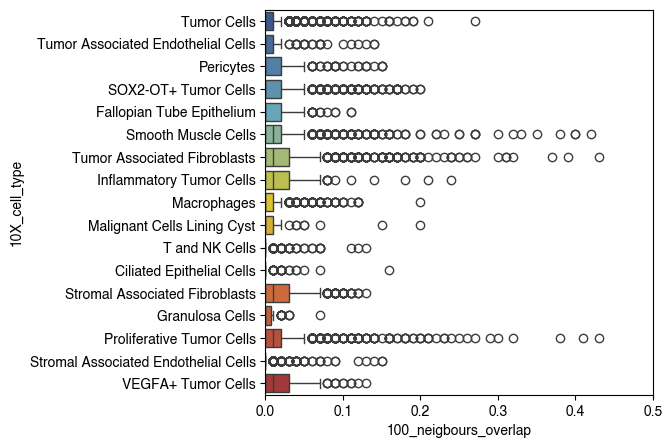

In [27]:
plt.figure(figsize=(5, 5))
plot_data_tmp = test_data.obs[test_data.obs['10X_cell_type'] != 'Unassigned'].copy()
plot_data_tmp["10X_cell_type"] = plot_data_tmp["10X_cell_type"].cat.remove_unused_categories()
plot_data_tmp["10X_cell_type"] = plot_data_tmp["10X_cell_type"].cat.reorder_categories(list(cluster_to_color_celltype.keys()), ordered=True)
sns.boxplot(
    data=plot_data_tmp,
    y="10X_cell_type",
    x="100_neigbours_overlap",
    hue="10X_cell_type",
    legend=False,
    palette=cluster_to_color_celltype,
    # orient='h',
)
plt.xlim([0,0.5])
plt.savefig(f'{figures_directory}/Fig_S4c.pdf', dpi=600, bbox_inches='tight')

## Fig S4d Macrophages

In [28]:
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with GPU-accelerated computations.")
    
    # import packages for GPU-accelerated analysis
    import rmm
    import cupy as cp
    import rapids_singlecell as rsc
    from cuml.manifold import TSNE
    
    from rmm.allocators.cupy import rmm_cupy_allocator

    # initialize RAPIDS memory manager
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=2 << 30,  # 2GB
        devices=list(map(int, os.environ.get("CUDA_VISIBLE_DEVICES").split(","))),
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)
    
    plot_macs = plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'].copy()

    rsc.pp.scale(plot_macs)
    rsc.pp.neighbors(plot_macs, n_neighbors=5, use_rep='X')
    rsc.tl.leiden(plot_macs, resolution=0.4, key_added='vitmae_leiden_macs')

    # Convert Leiden clusters to 1-based index
    plot_macs.obs['vitmae_leiden_macs'] = plot_macs.obs['vitmae_leiden_macs'].astype(int).add(1).astype(str).astype('category')
    
    merged_obs = plot_data.obs.merge(
        plot_macs.obs[['cell_id', 'vitmae_leiden_macs']],
        right_on='cell_id',
        left_on='cell_id',
        how='left'
    )
    plot_data.obs = merged_obs

    macs_clusters = plot_data.obs[(plot_data.obs['10X_cell_type'] == 'Macrophages') & (plot_data.obs['is_in_vitmae_test_set'])][['cell_id','vitmae_leiden_macs']].copy()
    macs_clusters.to_csv('../figure_data/input_data_Xenium/test_set_macs_clusters.csv', index=False)
else:
    print("GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.")
    vitmae_leiden_macs = pd.read_csv('../figure_data/input_data_Xenium/test_set_macs_clusters.csv')
    vitmae_leiden_macs["vitmae_leiden_macs"] = vitmae_leiden_macs["vitmae_leiden_macs"].fillna(-1).astype(int)

    # add annotation to the plot_data object
    plot_data.obs['vitmae_leiden_macs'] = plot_data.obs.merge(vitmae_leiden_macs, on = "cell_id", how = "left")["vitmae_leiden_macs"].fillna(-1).astype(int).values
    plot_data.obs['vitmae_leiden_macs'] = plot_data.obs['vitmae_leiden_macs'].astype(str).astype('category')
    plot_data.obs["vitmae_leiden_macs"].replace('-1', np.nan, inplace=True)
    plot_data.obs["vitmae_leiden_macs"] = plot_data.obs["vitmae_leiden_macs"].cat.remove_unused_categories()

GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.


/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_78954/2516571879.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  plot_data.obs["vitmae_leiden_macs"].replace('-1', np.nan, inplace=True)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_78954/2516571879.py:48: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categorie

In [36]:
groups_to_plot = ['2', '3', '4', '5', '8', '6', '1', '7']

palette = generate_palette(len(groups_to_plot), custom_cmap=custom_cmap)
cluster_to_color = {cluster_label:palette[i] for i, cluster_label in enumerate(groups_to_plot)}

# dump to json file for reloading
with open('../figure_data/color_palettes/FigS4d_cluster_to_color.json', 'w') as f:
    json.dump(cluster_to_color, f)

# white
na_color = (
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
    np.float64(1.0),
)
cats = list(plot_data.obs['vitmae_leiden_macs'].cat.categories)
plot_data.uns['vitmae_leiden_macs_colors'] = [cluster_to_color.get(c, na_color) for c in cats]

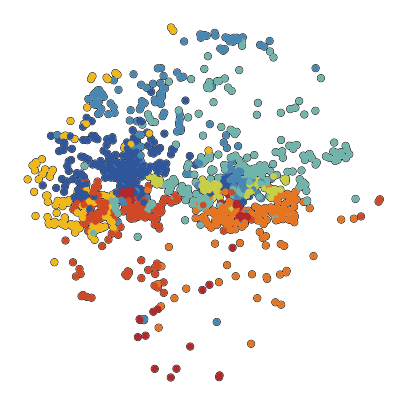

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
    legend_loc=None,
)
fig.savefig(f'{figures_directory}/Fig_S4d.png', dpi=600, bbox_inches='tight',)

1 extra bytes in post.stringData array


'created' timestamp seems very low; regarding as unix timestamp


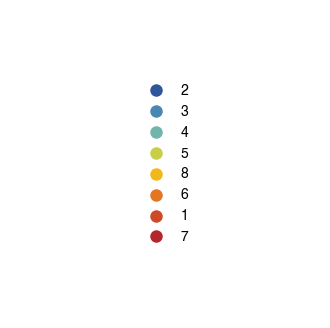

In [33]:
# Create figure containing the legend to the previously generated tSNE
df = pd.DataFrame({
    'vitmae_leiden_macs': groups_to_plot,
    'color': palette,
})

fig, ax = plt.subplots(figsize=(4, 4))
ax.axis("off")

# Build legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=row['vitmae_leiden_macs'])
    for _, row in df.iterrows()
]
ax.legend(handles=handles, loc='center', frameon=False)
fig.savefig(f"{figures_directory}/Fig_S4d_tSNE_legend.pdf", dpi=300, bbox_inches="tight")

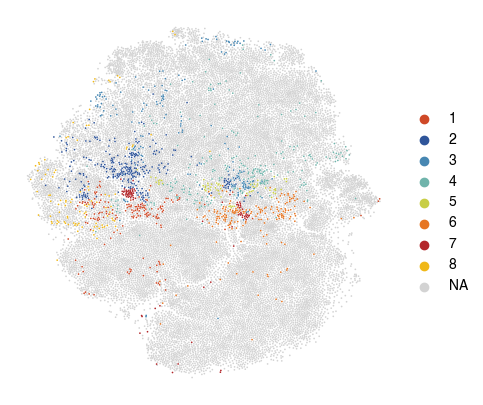

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data,
    color = 'vitmae_leiden_macs',
    ax = ax,
    alpha = 1,
    frameon=False,
    title='',
    na_color='lightgrey',
    groups=groups_to_plot,
)

/fs/home/schmacke/miniforge3/envs/rapids/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1148: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


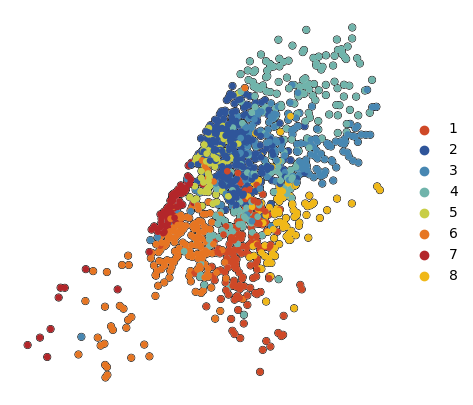

In [ ]:
# make an alternative UMAP visualization

rsc.pp.neighbors(plot_data, n_neighbors=15)
rsc.tl.umap(plot_data)

fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(
    plot_data[plot_data.obs['10X_cell_type'] == 'Macrophages'],
    color = 'vitmae_leiden_macs',
    ax = ax,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    title='',
    na_color='white',
    groups=groups_to_plot,
)

## Fig S4e Map Macrophages onto Tissue

In [41]:
color_map = "../figure_data/color_palettes/FigS4d_cluster_to_color.json"
path_macrophage_leiden_cluster_annotation_test_set = '../figure_data/input_data_Xenium/test_set_macs_clusters.csv'

In [42]:
with open(color_map, "rb") as f:
    palette = json.load(f)

In [46]:
adata = sdata["table"].copy()

#add macrophage annotation
annotation_macrophages = pd.read_csv(path_macrophage_leiden_cluster_annotation_test_set)
annotation_macrophages.columns = ["cell_id", "vitmae_leiden_macs_test"]
annotation_macrophages.vitmae_leiden_macs_test = annotation_macrophages.vitmae_leiden_macs_test.astype('int').astype(str)
annotation_macrophages.vitmae_leiden_macs_test = annotation_macrophages.vitmae_leiden_macs_test.astype('category')

adata.obs = adata.obs.merge(annotation_macrophages, on = "cell_id", how = "left")

sdata["table"].obs = adata.obs

annotation = sdata.table.copy()
annotation.uns["spatialdata_attrs"]["region"] = "centers_seg_all_cytosol"
annotation.obs["region"] = "centers_seg_all_cytosol"

sdata["table_centers"] = annotation

/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_78954/3141082578.py:13: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  annotation = sdata.table.copy()
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


INFO     Rasterizing image for faster rendering.                                                                   
WARNING  One cmap was given for multiple channels and is now used for each channel. You're blending multiple cmaps.
         If the plot doesn't look like you expect, it might be because your cmaps go from a given color to 'white',
         and not to 'transparent'. Therefore, the 'white' of higher layers will overlay the lower layers. Consider 
         using 'palette' instead.                                                                                  


/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/basic.py:952: UserWarning: Annotating points with vitmae_leiden_macs_test which is stored in the table `table_centers`. To improve performance, it is advisable to store point annotations directly in the .parquet file.
  _render_points(
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_centers` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge

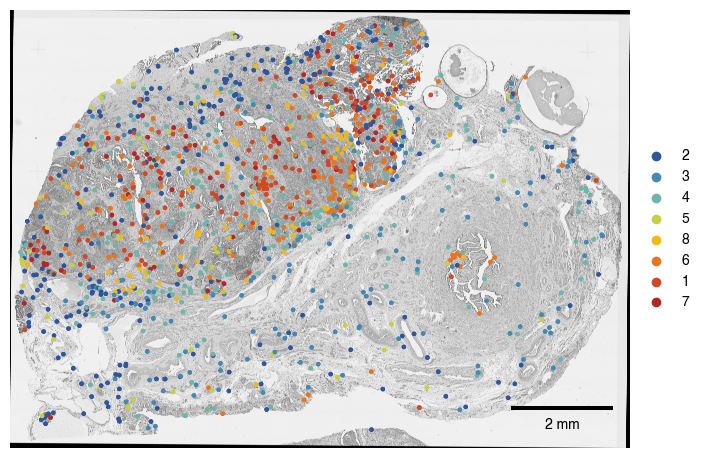

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


In [49]:
fig, axs = plt.subplots(1, 1, figsize = (8, 8))
sdata.pl.render_images('he_image',alpha = 1, cmap = "gray").pl.show(ax = axs)

# set up color scheme for points plot
groups = list(palette.keys())
colors = [to_hex(x) for x in list(palette.values())]

sdata.pl.render_points('centers_seg_all_cytosol', 
                       color = "vitmae_leiden_macs_test", 
                       groups = groups,
                       palette = colors,
                       size = 5,
                       method = "matplotlib").pl.show(ax = axs)

scportrait.pl.add_scalebar(axs, resolution = px_size, color = "black")

axs.axis("off")
axs.set_title(None)
plt.show()

fig.savefig(f"{figures_directory}/FigS4e_spatialplot_macrophage_clusters_overlayed_HE.pdf", bbox_inches = "tight")

## Fig S4f tissue annotation 

Was exported from Qupath using the original input file: ../input_data/Xenium_ovarian_cancer/raw_input_data/Xenium_Prime_Ovarian_Cancer_FFPE_XRrun_he_annotated_image.ome.tif

## Fig S4g Differentially Expressed Genes between Macrophage Leiden Clusters

In [52]:
data_genes = data.copy()
data_genes = data_genes[data_genes.obs['is_in_vitmae_test_set']]

merged_obs = data_genes.obs.merge(
    plot_data.obs[['cell_id', 'vitmae_leiden_macs']],
    right_on='cell_id',
    left_on='cell_id',
    how='left'
)
data_genes.obs = merged_obs

data_genes_macs = data_genes[data_genes.obs['cell_type'] == 'Macrophages'].copy()

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.pp.normalize_total(data_genes_macs, target_sum=10e4)

log1p is necessary here, because DE gene analysis is sensitive to high-variance outlier genes. In contrast to embedding into SCimilarity, the absolute range of values does not matter here.

In [ ]:
sc.pp.log1p(data_genes_macs)

In [ ]:
sc.pp.pca(data_genes_macs)
sc.tl.rank_genes_groups(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    method="wilcoxon"
)
sc.tl.dendrogram(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 5101 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


In [54]:
data_genes_macs.uns['rank_genes_groups']['pvals_adj']

rec.array([(1.85072515e-14, 0.06838251, 2.66040498e-15, 3.07491513e-03, 1., 1.35726508e-10, 3.82447561e-05, 1.15467925e-10),
           (3.26057541e-14, 0.18714723, 1.13305024e-10, 1.00000000e+00, 1., 6.69169260e-10, 4.02243902e-04, 2.83212609e-10),
           (8.21324595e-09, 1.        , 6.18200009e-06, 1.00000000e+00, 1., 4.26492135e-03, 3.68822234e-03, 8.74509098e-08),
           ...,
           (1.29951219e-01, 0.18714723, 6.62705661e-04, 4.04108158e-02, 1., 1.24286605e-02, 3.39755772e-01, 1.00000000e+00),
           (2.09695777e-02, 0.18714723, 1.36279068e-05, 4.37956113e-05, 1., 1.06856497e-03, 2.72750451e-01, 1.00000000e+00),
           (8.43173516e-04, 0.06838251, 4.96187804e-12, 2.30786202e-06, 1., 1.35726508e-10, 1.61595516e-01, 1.00000000e+00)],
          dtype=[('1', '<f8'), ('2', '<f8'), ('3', '<f8'), ('4', '<f8'), ('5', '<f8'), ('6', '<f8'), ('7', '<f8'), ('8', '<f8')])

In [58]:
color_list_blue = ['#FFFFFF','#2F559A']
custom_cmap_blue = LinearSegmentedColormap.from_list('custom_gradient', color_list_blue)

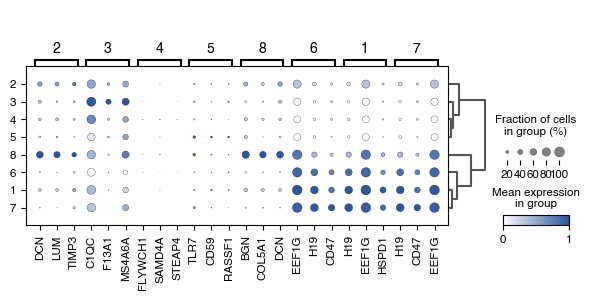

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


In [60]:
fig, ax = plt.subplots(figsize=(7, 2.8)) #8,3
dp = sc.pl.rank_genes_groups_dotplot(
    data_genes_macs,
    groupby="vitmae_leiden_macs",
    standard_scale="var",
    n_genes=3,
    cmap=custom_cmap_blue,
    ax=ax,
    min_logfoldchange=1.5,
    # groups=groups_to_plot,
    dendrogram=True,
    return_fig=True,
)
dp.style(largest_dot=50) #120
dp.show()
fig.tight_layout()
fig.savefig(f'{figures_directory}/Fig_S4g.pdf')